In [1]:
!apt install sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrwb0 amd64 0.1.3-2.1 [45.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main a

### Baseline commands recognition (2-5 points)

We're now going to train a classifier to recognize voice. More specifically, we'll use the [Speech Commands Dataset] that contains around 30 different words with a few thousand voice records each.

In [2]:
import os
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import librosa
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchvision.transforms as T
from scipy.io import wavfile
import IPython.display as ipd

device = 'cuda'

In [2]:
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2021-10-24 14:31:22--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.13.128, 2a00:1450:400c:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.13.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  88.0MB/s    in 18s     

2021-10-24 14:31:41 (76.8 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [3]:
!sox --info speech_commands/bed/00176480_nohash_0.wav


Input File     : 'speech_commands/bed/00176480_nohash_0.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



### Нарисуем спектрограмму для файлика с комнадой "right"

In [3]:
def show_spectrogram(wav_path):

    # Read the wav file (mono)
    samplingFrequency, signalData = wavfile.read(wav_path)

    plt.subplot(211)
    plt.title('Spectrogram of a wav file')

    plt.plot(signalData)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude') 

    plt.subplot(212)
    plt.specgram(signalData,Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.show()
    return ipd.Audio(wav_path)

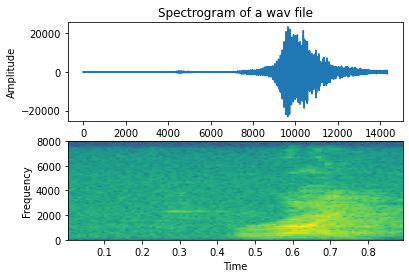

In [5]:
show_spectrogram('/content/speech_commands/right/00b01445_nohash_0.wav')

### Подготовка данных

In [6]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
import joblib as jl

classes = ("left", "right", "up", "down", "stop")

def preprocess_sample(filepath, max_length=150):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

100%|██████████| 11834/11834 [07:32<00:00, 26.13it/s]


### Модель с 2d-свертками
* __Подготовка данных:__ поскольку модель на 2d-свертки, то нужно добавить количество каналов(1) в шейп тензора данных;
* __Подготовка выборки:__ разделим данные на трейн и тест и объявим даталоудеры
* __Batch size:__ Возьмем batch_size = 16

In [7]:
# X.shape
X_r = X[:,None,:,:]
X_r.shape

(11834, 1, 150, 128)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y, random_state=42)

In [9]:
batch_size = 16

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

### Модель
__Примечание:__ Был выбран оптимизатор Adam, поскольку с использованием SGD лосс почти не менялся даже при подборе разного шага (learning rate)

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class Net2d(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        # self.bn1 = nn.BatchNorm2D(16)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(4, 2)

        self.conv3 = nn.Conv2d(32, 64, 5)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(6, 2)

        self.conv4 = nn.Conv2d(64, 128, 5)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(6, 2)


        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 5)

    def forward(self, x):
        # TODO: apply your layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        return F.softmax(x)


net2d = Net2d().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2d.parameters(), lr=0.003)#, momentum=0.9)

### Объявим функцию обучения модели
__Параметры:__
* модель
* данные для обучения
* количество эпох

Функция возвращает лосс

In [10]:
def model_train(model, trainloader, epochs):
  total_step = len(trainloader)
  losses, epoch_losses = [], []
  for epoch in range(epochs):  # loop over the dataset multiple times
      model.train()
      running_loss = 0.0
      epoch_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()     
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          epoch_loss += loss.item()
          if (i+1) % 50 == 0:    # print every 50 mini-batches
              print('Epoch [{}/{}], Step [{}/{}], loss: {:.3f}'
                  .format(epoch, epochs, i+1, total_step, running_loss / 50))
              running_loss = 0.0
      epoch_losses.append(epoch_loss)


  print('Finished Training')
  return epoch_losses

### Предсказания на тестовых данных

Посмотрим accuracy (в том числе и для каждого класса)

In [16]:
def model_predict(model, testloader):
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  correct = 0
  total = 0

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          _, predictions = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predictions == labels).sum().item()
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print('Total accuracy: %d %%' % (
      100 * correct / total))
  return

In [28]:
epoch_losses = model_train(net2d, trainloader, 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0/20], Step [50/555], loss: 1.587
Epoch [0/20], Step [100/555], loss: 1.569
Epoch [0/20], Step [150/555], loss: 1.542
Epoch [0/20], Step [200/555], loss: 1.531
Epoch [0/20], Step [250/555], loss: 1.476
Epoch [0/20], Step [300/555], loss: 1.477
Epoch [0/20], Step [350/555], loss: 1.416
Epoch [0/20], Step [400/555], loss: 1.452
Epoch [0/20], Step [450/555], loss: 1.436
Epoch [0/20], Step [500/555], loss: 1.388
Epoch [0/20], Step [550/555], loss: 1.427
Epoch [1/20], Step [50/555], loss: 1.402
Epoch [1/20], Step [100/555], loss: 1.330
Epoch [1/20], Step [150/555], loss: 1.382
Epoch [1/20], Step [200/555], loss: 1.354
Epoch [1/20], Step [250/555], loss: 1.320
Epoch [1/20], Step [300/555], loss: 1.367
Epoch [1/20], Step [350/555], loss: 1.314
Epoch [1/20], Step [400/555], loss: 1.338
Epoch [1/20], Step [450/555], loss: 1.357
Epoch [1/20], Step [500/555], loss: 1.334
Epoch [1/20], Step [550/555], loss: 1.307
Epoch [2/20], Step [50/555], loss: 1.384
Epoch [2/20], Step [100/555], loss: 1

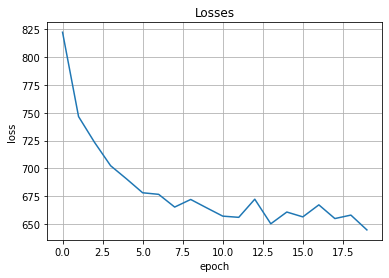

In [29]:
plt.plot(epoch_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title('Losses')

In [32]:
model_predict(net2d, testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy for class left  is: 78.9 %
Accuracy for class right is: 81.7 %
Accuracy for class up    is: 78.6 %
Accuracy for class down  is: 83.0 %
Accuracy for class stop  is: 75.0 %
Total accuracy: 79 %


## Построим модель на 1d-свертках

In [33]:
X_train1d, X_test1d, y_train1d, y_test1d = train_test_split(X, y, random_state=42)

In [34]:
batch_size = 16

tensor_x1d = torch.Tensor(X_train1d)
tensor_y1d = torch.LongTensor(y_train1d)

train_dataset1d = TensorDataset(tensor_x1d, tensor_y1d)

tensor_x1d = torch.Tensor(X_test1d) # transform to torch tensor
tensor_y1d = torch.LongTensor(y_test1d)

test_dataset1d = TensorDataset(tensor_x1d, tensor_y1d)


trainloader1d = DataLoader(train_dataset1d, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader1d = DataLoader(test_dataset1d, batch_size=batch_size,
                        shuffle=False, num_workers=2)

In [35]:
X_train1d.shape

(8875, 150, 128)

In [36]:
import torch.nn as nn
import torch.nn.functional as F


class Net1d(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv1d(150, 16, 5)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2, 2)
        # self.bn1 = nn.BatchNorm2D(16)

        self.conv2 = nn.Conv1d(16, 32, 5)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(4, 2)

        self.conv3 = nn.Conv1d(32, 64, 5)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(6, 2)

        self.conv4 = nn.Conv1d(64, 128, 5)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool4 = nn.MaxPool1d(6, 2)


        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(128, 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 5)
        # self.relu2 = nn.ReLU()
        # self.dense3 = nn.Linear(32, 5)

    def forward(self, x):
        # TODO: apply your layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        # x = self.relu2(x)
        # x = self.dense3(x)
        return F.softmax(x)


net1d = Net1d().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1d.parameters(), lr=0.003)#, momentum=0.9)

In [37]:
epoch_losses1d = model_train(net1d, trainloader1d, 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0/20], Step [50/555], loss: 1.610
Epoch [0/20], Step [100/555], loss: 1.599
Epoch [0/20], Step [150/555], loss: 1.602
Epoch [0/20], Step [200/555], loss: 1.596
Epoch [0/20], Step [250/555], loss: 1.573
Epoch [0/20], Step [300/555], loss: 1.576
Epoch [0/20], Step [350/555], loss: 1.549
Epoch [0/20], Step [400/555], loss: 1.539
Epoch [0/20], Step [450/555], loss: 1.554
Epoch [0/20], Step [500/555], loss: 1.536
Epoch [0/20], Step [550/555], loss: 1.542
Epoch [1/20], Step [50/555], loss: 1.535
Epoch [1/20], Step [100/555], loss: 1.528
Epoch [1/20], Step [150/555], loss: 1.539
Epoch [1/20], Step [200/555], loss: 1.500
Epoch [1/20], Step [250/555], loss: 1.541
Epoch [1/20], Step [300/555], loss: 1.514
Epoch [1/20], Step [350/555], loss: 1.530
Epoch [1/20], Step [400/555], loss: 1.500
Epoch [1/20], Step [450/555], loss: 1.522
Epoch [1/20], Step [500/555], loss: 1.502
Epoch [1/20], Step [550/555], loss: 1.512
Epoch [2/20], Step [50/555], loss: 1.499
Epoch [2/20], Step [100/555], loss: 1

In [39]:
model_predict(net1d, testloader1d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy for class left  is: 70.9 %
Accuracy for class right is: 51.2 %
Accuracy for class up    is: 50.2 %
Accuracy for class down  is: 42.4 %
Accuracy for class stop  is: 48.5 %
Total accuracy: 52 %


### Сравнение лоссов
Модель с 2d-свертками побеждает

Text(0.5, 1.0, 'Losses')

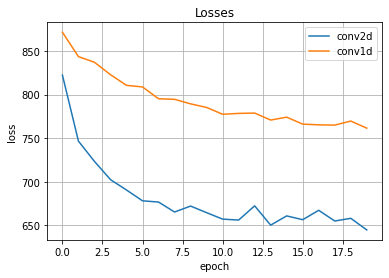

In [41]:
plt.plot(epoch_losses, '-', label='conv2d')
plt.plot(epoch_losses1d, '-', label='conv1d')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title('Losses')

### Используем готовую модель: ResNet

In [52]:
import torchvision.models as models

resnet = models.resnet.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet = resnet.to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.003)#, momentum=0.9)

In [54]:
epoch_losses_resnet = model_train(resnet, trainloader, 20)

Epoch [0/20], Step [50/555], loss: 2.114
Epoch [0/20], Step [100/555], loss: 1.685
Epoch [0/20], Step [150/555], loss: 1.682
Epoch [0/20], Step [200/555], loss: 1.511
Epoch [0/20], Step [250/555], loss: 1.433
Epoch [0/20], Step [300/555], loss: 1.306
Epoch [0/20], Step [350/555], loss: 1.250
Epoch [0/20], Step [400/555], loss: 1.116
Epoch [0/20], Step [450/555], loss: 0.958
Epoch [0/20], Step [500/555], loss: 0.810
Epoch [0/20], Step [550/555], loss: 0.718
Epoch [1/20], Step [50/555], loss: 0.624
Epoch [1/20], Step [100/555], loss: 0.580
Epoch [1/20], Step [150/555], loss: 0.515
Epoch [1/20], Step [200/555], loss: 0.598
Epoch [1/20], Step [250/555], loss: 0.475
Epoch [1/20], Step [300/555], loss: 0.420
Epoch [1/20], Step [350/555], loss: 0.465
Epoch [1/20], Step [400/555], loss: 0.371
Epoch [1/20], Step [450/555], loss: 0.375
Epoch [1/20], Step [500/555], loss: 0.344
Epoch [1/20], Step [550/555], loss: 0.324
Epoch [2/20], Step [50/555], loss: 0.311
Epoch [2/20], Step [100/555], loss: 0

In [56]:
model_predict(resnet, testloader)

Accuracy for class left  is: 93.9 %
Accuracy for class right is: 96.9 %
Accuracy for class up    is: 97.3 %
Accuracy for class down  is: 90.4 %
Accuracy for class stop  is: 89.6 %
Total accuracy: 93 %


### Какое восхитительное качество показала модель ResNet!

Ниже для сравнения приведены лоссы трех моделей. ResNet справляется очень хорошо:)

Text(0.5, 1.0, 'Losses')

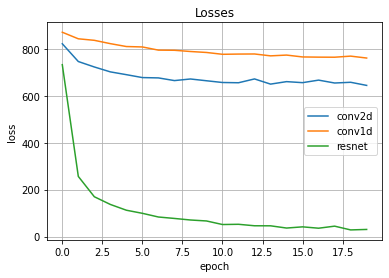

In [57]:
plt.plot(epoch_losses, '-', label='conv2d')
plt.plot(epoch_losses1d, '-', label='conv1d')
plt.plot(epoch_losses_resnet, '-', label='resnet')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title('Losses')

Train a model: finally, lets' build and train a classifier neural network. You can use any library you like. If in doubt, consult the model & training tips below.

__Training tips:__ here's what you can try:
* __Layers:__ 1d or 2d convolutions, perhaps with some batch normalization in between;
* __Architecture:__ VGG-like, residual, highway, densely-connected, MatchboxNet, Dilated convs - you name it :)
* __Batch size matters:__ smaller batches usually train slower but better. Try to find the one that suits you best.
* __Data augmentation:__ add background noise, faster/slower, change pitch;
* __Average checkpoints:__ you can make model more stable with [this simple technique (arxiv)](https://arxiv.org/abs/1803.05407)
* __For full scale stage:__ make sure you're not losing too much data due to max_length in the pre-processing stage!

These are just recommendations. As long as your model works, you're not required to follow them.

### Full scale commands recognition (3+ points)

Your final task is to train a full-scale voice command spotter and apply it to a video:
1. Build the dataset with all 30+ classes (directions, digits, names, etc.)
  * __Optional:__ include a special "noise" class that contains random unrelated sounds
  * You can download youtube videos with [`youtube-dl`](https://ytdl-org.github.io/youtube-dl/index.html) library.
2. Train a model on this full dataset. Kudos for tuning its accuracy :)
3. Apply it to a audio/video of your choice to spot the occurences of each keyword
 * Here's one [video about primes](https://www.youtube.com/watch?v=EK32jo7i5LQ) that you can try. It should be full of numbers :)
 * There are multiple ways you can analyze the performance of your network, e.g. plot probabilities predicted for every time-step. Chances are you'll discover something useful about how to improve your model :)


Please briefly describe what you did in a short informal report.

### Обучение на всем датасете
Датасет слишком большой, поэтому пришлось обрабатывать его по частям. В ноутбуке финальные файлы

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open('/content/drive/MyDrive/speech_technology/X_train.pickle', 'rb') as f:
  X_train = pickle.load(f)
  
with open('/content/drive/MyDrive/speech_technology/X_test.pickle', 'rb') as f:
  X_test = pickle.load(f)

with open('/content/drive/MyDrive/speech_technology/y_train.pickle', 'rb') as f:
  y_train = pickle.load(f)

with open('/content/drive/MyDrive/speech_technology/y_test.pickle', 'rb') as f:
  y_test = pickle.load(f)

In [6]:
X_train.shape

(48539, 150, 128)

In [7]:
# X.shape
X_train_r = X_train[:,None,:,:]
X_test_r = X_test[:,None,:,:]

In [8]:
batch_size = 64

tensor_x = torch.Tensor(X_train_r)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test_r) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

resnet = models.resnet.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet = resnet.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.003)

In [12]:
losses = model_train(resnet, trainloader, 10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0/10], Step [50/759], loss: 3.800
Epoch [0/10], Step [100/759], loss: 3.215
Epoch [0/10], Step [150/759], loss: 2.832
Epoch [0/10], Step [200/759], loss: 2.424
Epoch [0/10], Step [250/759], loss: 2.063
Epoch [0/10], Step [300/759], loss: 1.741
Epoch [0/10], Step [350/759], loss: 1.520
Epoch [0/10], Step [400/759], loss: 1.337
Epoch [0/10], Step [450/759], loss: 1.214
Epoch [0/10], Step [500/759], loss: 1.077
Epoch [0/10], Step [550/759], loss: 0.986
Epoch [0/10], Step [600/759], loss: 0.933
Epoch [0/10], Step [650/759], loss: 0.863
Epoch [0/10], Step [700/759], loss: 0.800
Epoch [0/10], Step [750/759], loss: 0.782
Epoch [1/10], Step [50/759], loss: 0.742
Epoch [1/10], Step [100/759], loss: 0.670
Epoch [1/10], Step [150/759], loss: 0.666
Epoch [1/10], Step [200/759], loss: 0.623
Epoch [1/10], Step [250/759], loss: 0.634
Epoch [1/10], Step [300/759], loss: 0.600
Epoch [1/10], Step [350/759], loss: 0.582
Epoch [1/10], Step [400/759], loss: 0.590
Epoch [1/10], Step [450/759], loss: 

Text(0.5, 1.0, 'Losses')

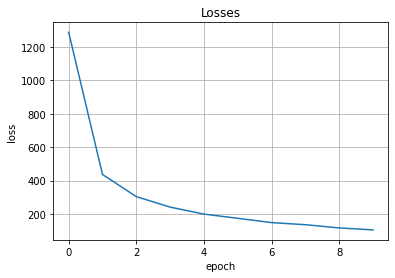

In [13]:
plt.plot(losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title('Losses')

In [14]:
correct = 0
total = 0

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        # collect the correct predictions for each class
print('Total accuracy: %d %%' % (
    100 * correct / total))

Total accuracy: 83 %


### Применение модели на видео

In [3]:
!pip install youtube_dl

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [15]:
import youtube_dl

In [40]:
ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '256'
    }],
    'postprocessor_args': [
        '-ar', '16000',
        '-ac', '1'  #mono
        
    ],
    'prefer_ffmpeg': True,
    'keepvideo': True
    
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=EK32jo7i5LQ'])

[youtube] EK32jo7i5LQ: Downloading webpage
[download] Destination: Why do prime numbers make these spirals _ Dirichlet’s theorem-EK32jo7i5LQ.webm
[download] 100% of 22.81MiB in 05:10
[ffmpeg] Destination: Why do prime numbers make these spirals _ Dirichlet’s theorem-EK32jo7i5LQ.wav


In [41]:
!sox --info prime_numbers_1.wav


Input File     : 'prime_numbers_1.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:22:29.52 = 21592247 samples ~ 101214 CDDA sectors
File Size      : 43.2M
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


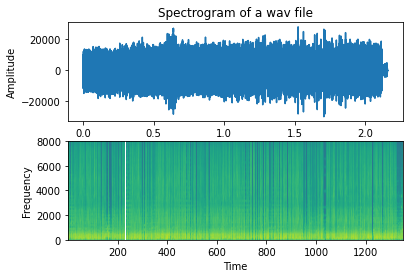

In [43]:
show_spectrogram('prime_numbers_mono.wav')

In [15]:
# словарь с индексами и названиями классов
classes = ['bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 
           'go', 'happy', 'house', 'marvin', 'nine', 'no', 'off', 'on',
           'left', 'right', 'up', 'down', 'stop', 'one', 'seven',
           'sheila', 'six', 'three', 'tree', 'two', 'wow', 'yes', 'zero']

classes_dict = {
    ind: word for ind, word in enumerate(classes)
}

### Спектрограмма

In [16]:
import joblib as jl

def preprocess_sample(filepath):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)
    return np.float32(spectrogram)

In [17]:
spectrogram = preprocess_sample('/content/drive/MyDrive/speech_technology/prime_numbers_mono.wav')

In [18]:
spectrogram.shape

(128, 58119)

### Нарезание спектрограммы на кусочки 1.5 секунды и подготовка даталоудера

In [23]:
parts = []
for i in range(0, spectrogram.shape[1]-150, 10):
  parts.append(spectrogram[:, i:i + 150])
parts = np.float32(parts)
parts = parts.transpose([0, 2, 1])
parts = parts[:, None, :, :]

batch_size = 64

tensor_video = torch.Tensor(parts)

video_dataset = TensorDataset(tensor_video)

videoloader = DataLoader(video_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
global_time = 0
with torch.no_grad():
    resnet.eval()
    for inputs in videoloader:
        # print(inputs[0].shape)
        inputs = inputs[0].to(device)
        outputs = F.softmax(resnet(inputs)[:, :30])
        _, predicted = torch.max(outputs.data, 1)
        
        for i, pred in enumerate(predicted):
          if outputs[i, pred].item() > 0.9:
            print(f'Time: {global_time} ms \t Predicted word is "{classes_dict[pred.item()]}"')
          global_time += 5

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


Time: 20 ms 	 Predicted word is "nine"
Time: 75 ms 	 Predicted word is "up"
Time: 250 ms 	 Predicted word is "happy"
Time: 255 ms 	 Predicted word is "happy"
Time: 260 ms 	 Predicted word is "happy"
Time: 265 ms 	 Predicted word is "happy"
Time: 270 ms 	 Predicted word is "happy"
Time: 275 ms 	 Predicted word is "happy"
Time: 280 ms 	 Predicted word is "happy"
Time: 285 ms 	 Predicted word is "happy"
Time: 290 ms 	 Predicted word is "happy"
Time: 295 ms 	 Predicted word is "happy"
Time: 305 ms 	 Predicted word is "happy"
Time: 510 ms 	 Predicted word is "bird"
Time: 530 ms 	 Predicted word is "bird"
Time: 630 ms 	 Predicted word is "go"
Time: 945 ms 	 Predicted word is "bird"
Time: 1065 ms 	 Predicted word is "dog"
Time: 1115 ms 	 Predicted word is "happy"
Time: 1175 ms 	 Predicted word is "five"
Time: 1180 ms 	 Predicted word is "five"
Time: 1200 ms 	 Predicted word is "happy"
Time: 1205 ms 	 Predicted word is "up"
Time: 1340 ms 	 Predicted word is "happy"
Time: 1345 ms 	 Predicted wo

### Интересно получилось :)